# 1. Business Understanding

A retailer needs a very high turnover and just-in-time delivery of products to be successful. For this, very precise forecasts are needed, which allow exact statements about which stores in which departments make how much turnover per week. The question is therefore as follows: What is the weekly sales forecast for all stores of a fictitious store if we take into account the data of the last three years, demographic information (CPI, Unemployment, Temperature, etc.)? Deriving from this, what then is the sales per week per department within one of these stores?

# 2. Data and Data understanding

The data used for the notebook is divided into three files. They contain different features and the common attribute stores. 

## 2.1. Import of Relevant Modules

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn  
from sklearn.linear_model import LinearRegression
%matplotlib inline
sns.set()

## 2.2. Read Train Data

In [54]:
walmart_features_data = pd.read_csv('https://storage.googleapis.com/ml-service-repository-datastorage/Sales_Forecast_for_retail_store_features.csv') 
walmart_train_data = pd.read_csv('https://storage.googleapis.com/ml-service-repository-datastorage/Sales_Forecast_for_retail_store_train.csv')
walmart_stores_data = pd.read_csv('https://storage.googleapis.com/ml-service-repository-datastorage/Sales_Forecast_for_retail_store_stores.csv')

walmart_features_data.to_csv('walmart_features_data.csv', index=False)
walmart_train_data.to_csv('walmart_train_data.csv', index=False)
walmart_stores_data.to_csv('walmart_stores_data.csv', index=False)

In [55]:
walmart_train_data.head(5)

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [56]:
walmart_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [57]:
walmart_train_data.describe(include='all')

Store           Dept        Date   Weekly_Sales IsHoliday
count   421570.000000  421570.000000      421570  421570.000000    421570
unique            NaN            NaN         143            NaN         2
top               NaN            NaN  2011-12-23            NaN     False
freq              NaN            NaN        3027            NaN    391909
mean        22.200546      44.260317         NaN   15981.258123       NaN
std         12.785297      30.492054         NaN   22711.183519       NaN
min          1.000000       1.000000         NaN   -4988.940000       NaN
25%         11.000000      18.000000         NaN    2079.650000       NaN
50%         22.000000      37.000000         NaN    7612.030000       NaN
75%         33.000000      74.000000         NaN   20205.852500       NaN
max         45.000000      99.000000         NaN  693099.360000       NaN

In [58]:
walmart_train_data.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [59]:
walmart_train_data[walmart_train_data.duplicated(keep=False)] # existieren duplizierte Reihen ?

Empty DataFrame
Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
Index: []

In [60]:
walmart_train_data.isnull().sum() # existieren Nullwerte ? --> keine vorhanden

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

## 2.2.1. Descriptive Analysis

C:\Users\ar\AppData\Local\Temp\ipykernel_4668\3708834975.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(walmart_train_data['Weekly_Sales'])


<Axes: xlabel='Weekly_Sales', ylabel='Density'>

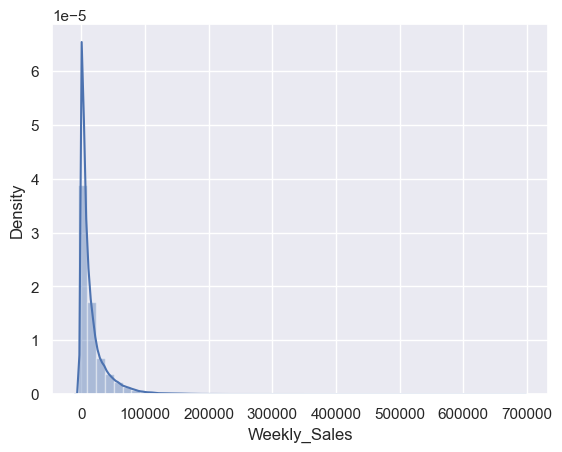

In [61]:
sns.distplot(walmart_train_data['Weekly_Sales'])

<Axes: >

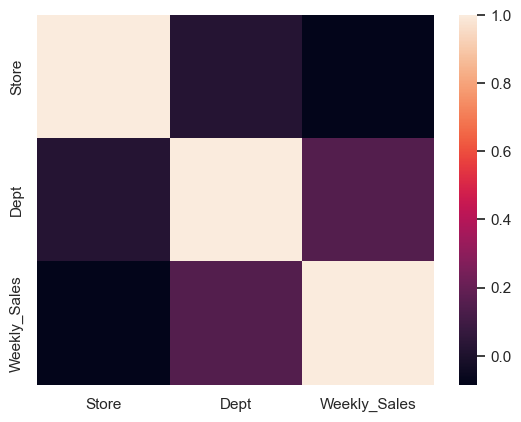

In [62]:
numeric_data = walmart_train_data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr())  # Betrachtung der Korrelation über eine heatmap

# 2.3. Read Features Data

In [63]:
walmart_features_data.head(5)

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

In [64]:
walmart_features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [65]:
walmart_features_data.describe(include='all')

Store        Date  Temperature   Fuel_Price      MarkDown1  \
count   8190.000000        8190  8190.000000  8190.000000    4032.000000   
unique          NaN         182          NaN          NaN            NaN   
top             NaN  2010-02-05          NaN          NaN            NaN   
freq            NaN          45          NaN          NaN            NaN   
mean      23.000000         NaN    59.356198     3.405992    7032.371786   
std       12.987966         NaN    18.678607     0.431337    9262.747448   
min        1.000000         NaN    -7.290000     2.472000   -2781.450000   
25%       12.000000         NaN    45.902500     3.041000    1577.532500   
50%       23.000000         NaN    60.710000     3.513000    4743.580000   
75%       34.000000         NaN    73.880000     3.743000    8923.310000   
max       45.000000         NaN   101.950000     4.468000  103184.980000   

            MarkDown2      MarkDown3     MarkDown4      MarkDown5  \
count     2921.000000    3613.000000   3464.000000    4050.000000   
unique            NaN            NaN           NaN            NaN   
top               NaN            NaN           NaN            NaN   
freq              NaN            NaN           NaN            NaN   
mean      3384.176594    1760.100180   3292.935886    4132.216422   
std       8793.583016   11276.462208   6792.329861   13086.690278   
min       -265.760000    -179.260000      0.220000    -185.170000   
25%         68.880000       6.600000    304.687500    1440.827500   
50%        364.570000      36.260000   1176.425000    2727.135000   
75%       2153.350000     163.150000   3310.007500    4832.555000   
max     104519.540000  149483.310000  67474.850000  771448.100000   

                CPI  Unemployment IsHoliday  
count   7605.000000   7605.000000      8190  
unique          NaN           NaN         2  
top             NaN           NaN     False  
freq            NaN           NaN      7605  
mean     172.460809      7.826821       NaN  
std       39.738346      1.877259       NaN  
min      126.064000      3.684000       NaN  
25%      132.364839      6.634000       NaN  
50%      182.764003      7.806000       NaN  
75%      213.932412      8.567000       NaN  
max      228.976456     14.313000       NaN

In [66]:
walmart_features_data.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')

In [67]:
walmart_features_data.isnull().sum() # existieren Nullwerte ?

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [68]:
null = pd.DataFrame(walmart_features_data.dtypes).T.rename(index={0: 'column Type'})
null = pd.concat([null, pd.DataFrame(walmart_features_data.isnull().sum()).T.rename(index={0: 'null values (nb)'})])
null = pd.concat([null, pd.DataFrame(walmart_features_data.isnull().sum() / walmart_features_data.shape[0] * 100).T.rename(index={0: 'null values (%)'})])

null

Store    Date Temperature Fuel_Price  MarkDown1  MarkDown2  \
column Type       int64  object     float64    float64    float64    float64   
null values (nb)      0       0           0          0       4158       5269   
null values (%)     0.0     0.0         0.0        0.0  50.769231  64.334554   

                  MarkDown3  MarkDown4  MarkDown5       CPI Unemployment  \
column Type         float64    float64    float64   float64      float64   
null values (nb)       4577       4726       4140       585          585   
null values (%)   55.885226  57.704518  50.549451  7.142857     7.142857   

                 IsHoliday  
column Type           bool  
null values (nb)         0  
null values (%)        0.0

In [69]:
from statistics import mean
walmart_features_data['CPI'] = walmart_features_data['CPI'].fillna(mean(walmart_features_data['CPI']))
walmart_features_data['Unemployment'] = walmart_features_data['Unemployment'].fillna(mean(walmart_features_data['Unemployment']))
walmart_features_data['MarkDown1'] = walmart_features_data['MarkDown1'].fillna(0)
walmart_features_data['MarkDown2'] = walmart_features_data['MarkDown2'].fillna(0)
walmart_features_data['MarkDown3'] = walmart_features_data['MarkDown3'].fillna(0)
walmart_features_data['MarkDown4'] = walmart_features_data['MarkDown4'].fillna(0)
walmart_features_data['MarkDown5'] = walmart_features_data['MarkDown5'].fillna(0)

## 2.3.2. Descriptive Analysis

<Axes: >

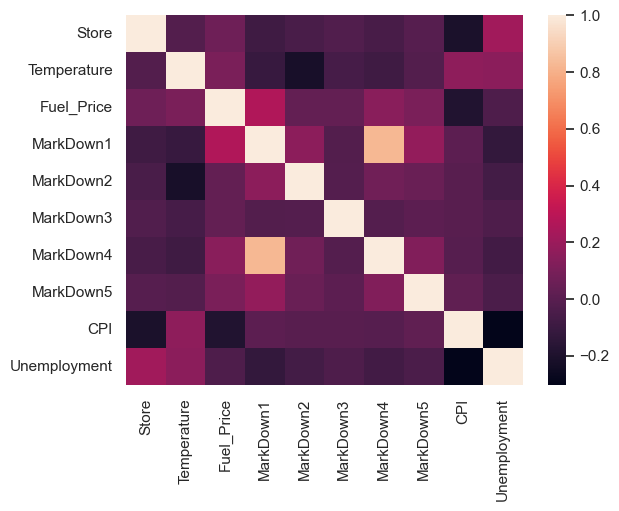

In [70]:
numeric_data = walmart_features_data.select_dtypes(include=[np.number])

sns.heatmap(numeric_data.corr())  # Betrachtung der Korrelation über eine heatmap

## 2.4. Read stores Data

In [71]:
walmart_stores_data.head(5)

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [72]:
walmart_stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [73]:
walmart_stores_data.describe(include='all')

Store Type           Size
count   45.000000   45      45.000000
unique        NaN    3            NaN
top           NaN    A            NaN
freq          NaN   22            NaN
mean    23.000000  NaN  130287.600000
std     13.133926  NaN   63825.271991
min      1.000000  NaN   34875.000000
25%     12.000000  NaN   70713.000000
50%     23.000000  NaN  126512.000000
75%     34.000000  NaN  202307.000000
max     45.000000  NaN  219622.000000

## 2.4.1. Descriptive Analysis

C:\Users\ar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


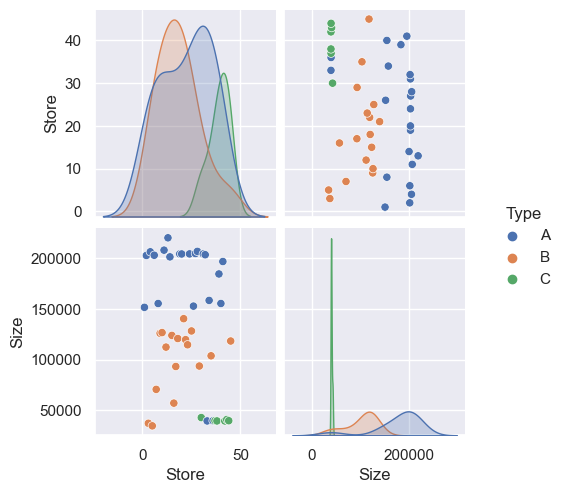

In [74]:
sns.pairplot(walmart_stores_data, vars=['Store', 'Size'], hue='Type')   # Betrachtung, ob der Typ an der Size hängt

C:\Users\ar\AppData\Local\Temp\ipykernel_4668\3085588910.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Type',y='Size',data=walmart_stores_data,palette='Set2')


<Axes: xlabel='Type', ylabel='Size'>

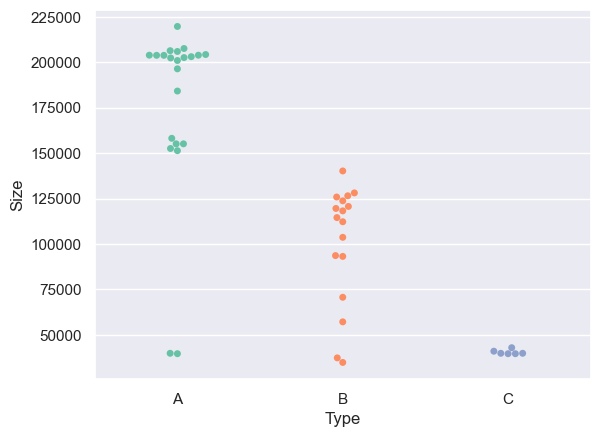

In [75]:
sns.swarmplot(x='Type',y='Size',data=walmart_stores_data,palette='Set2')

In [76]:
walmart_stores_data.loc[walmart_stores_data.Size < 50000, "Type"] = "C"
walmart_stores_data.loc[walmart_stores_data.Size >= 50000, "Type"] = "B"
walmart_stores_data.loc[walmart_stores_data.Size >= 150000, "Type"] = "A"

C:\Users\ar\AppData\Local\Temp\ipykernel_4668\3085588910.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Type',y='Size',data=walmart_stores_data,palette='Set2')


<Axes: xlabel='Type', ylabel='Size'>

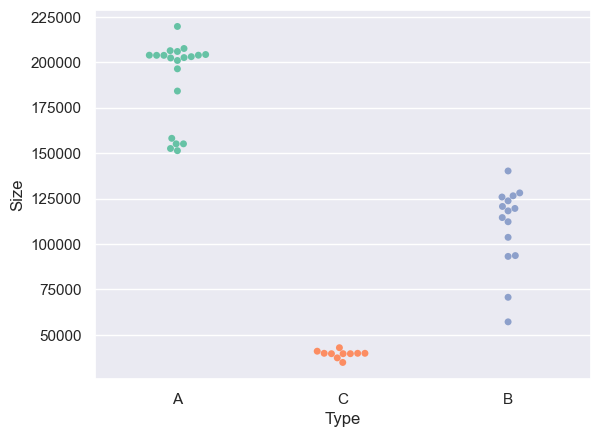

In [77]:
sns.swarmplot(x='Type',y='Size',data=walmart_stores_data,palette='Set2')

<Axes: xlabel='Type', ylabel='count'>

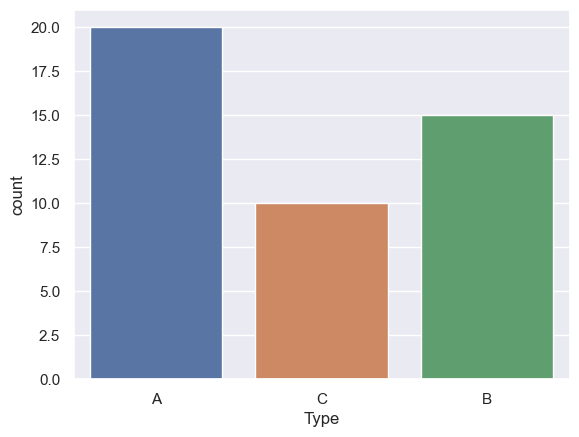

In [78]:
sns.countplot(x='Type',data=walmart_stores_data)   # Betrachtung, wieviele Läden wir von welchem Type haben

In [79]:
sizes=walmart_stores_data.count()['Size'].round(1)
print(sizes)

45


C:\Users\ar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


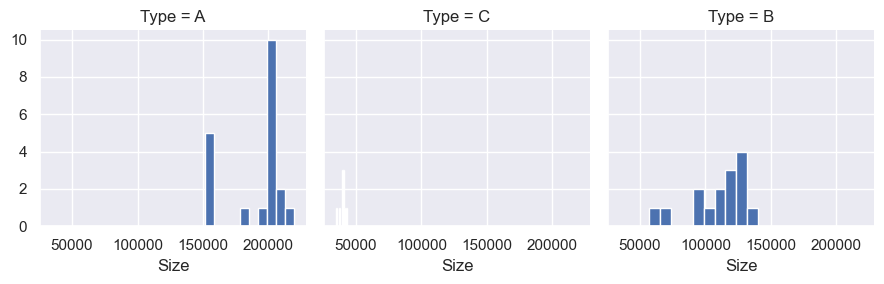

In [80]:
g = sns.FacetGrid(data=walmart_stores_data,col='Type')   # Betrachtung, wie sich inerhalb eines Types dann noch die Größe verteilt
g.map(plt.hist,'Size')

In [81]:
walmart_stores_data.columns

Index(['Store', 'Type', 'Size'], dtype='object')

In [82]:
walmart_stores_data.isnull().sum() # existieren Nullwerte ?

Store    0
Type     0
Size     0
dtype: int64

# 3. Data Preparation

In [83]:
festo_data = walmart_features_data.merge(walmart_stores_data, how='inner', on='Store')
comb_data = walmart_train_data.merge(festo_data, how='inner', on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept', 'Date']).reset_index(drop=True)

In [84]:
comb_data.head(5)

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     1  2010-02-12      46039.49       True        38.51       2.548   
2      1     1  2010-02-19      41595.55      False        39.93       2.514   
3      1     1  2010-02-26      19403.54      False        46.63       2.561   
4      1     1  2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.242170   
2        0.0        0.0        0.0        0.0        0.0  211.289143   
3        0.0        0.0        0.0        0.0        0.0  211.319643   
4        0.0        0.0        0.0        0.0        0.0  211.350143   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

In [85]:
comb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     421570 non-null  float64
 8   MarkDown2     421570 non-null  float64
 9   MarkDown3     421570 non-null  float64
 10  MarkDown4     421570 non-null  float64
 11  MarkDown5     421570 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


C:\Users\ar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


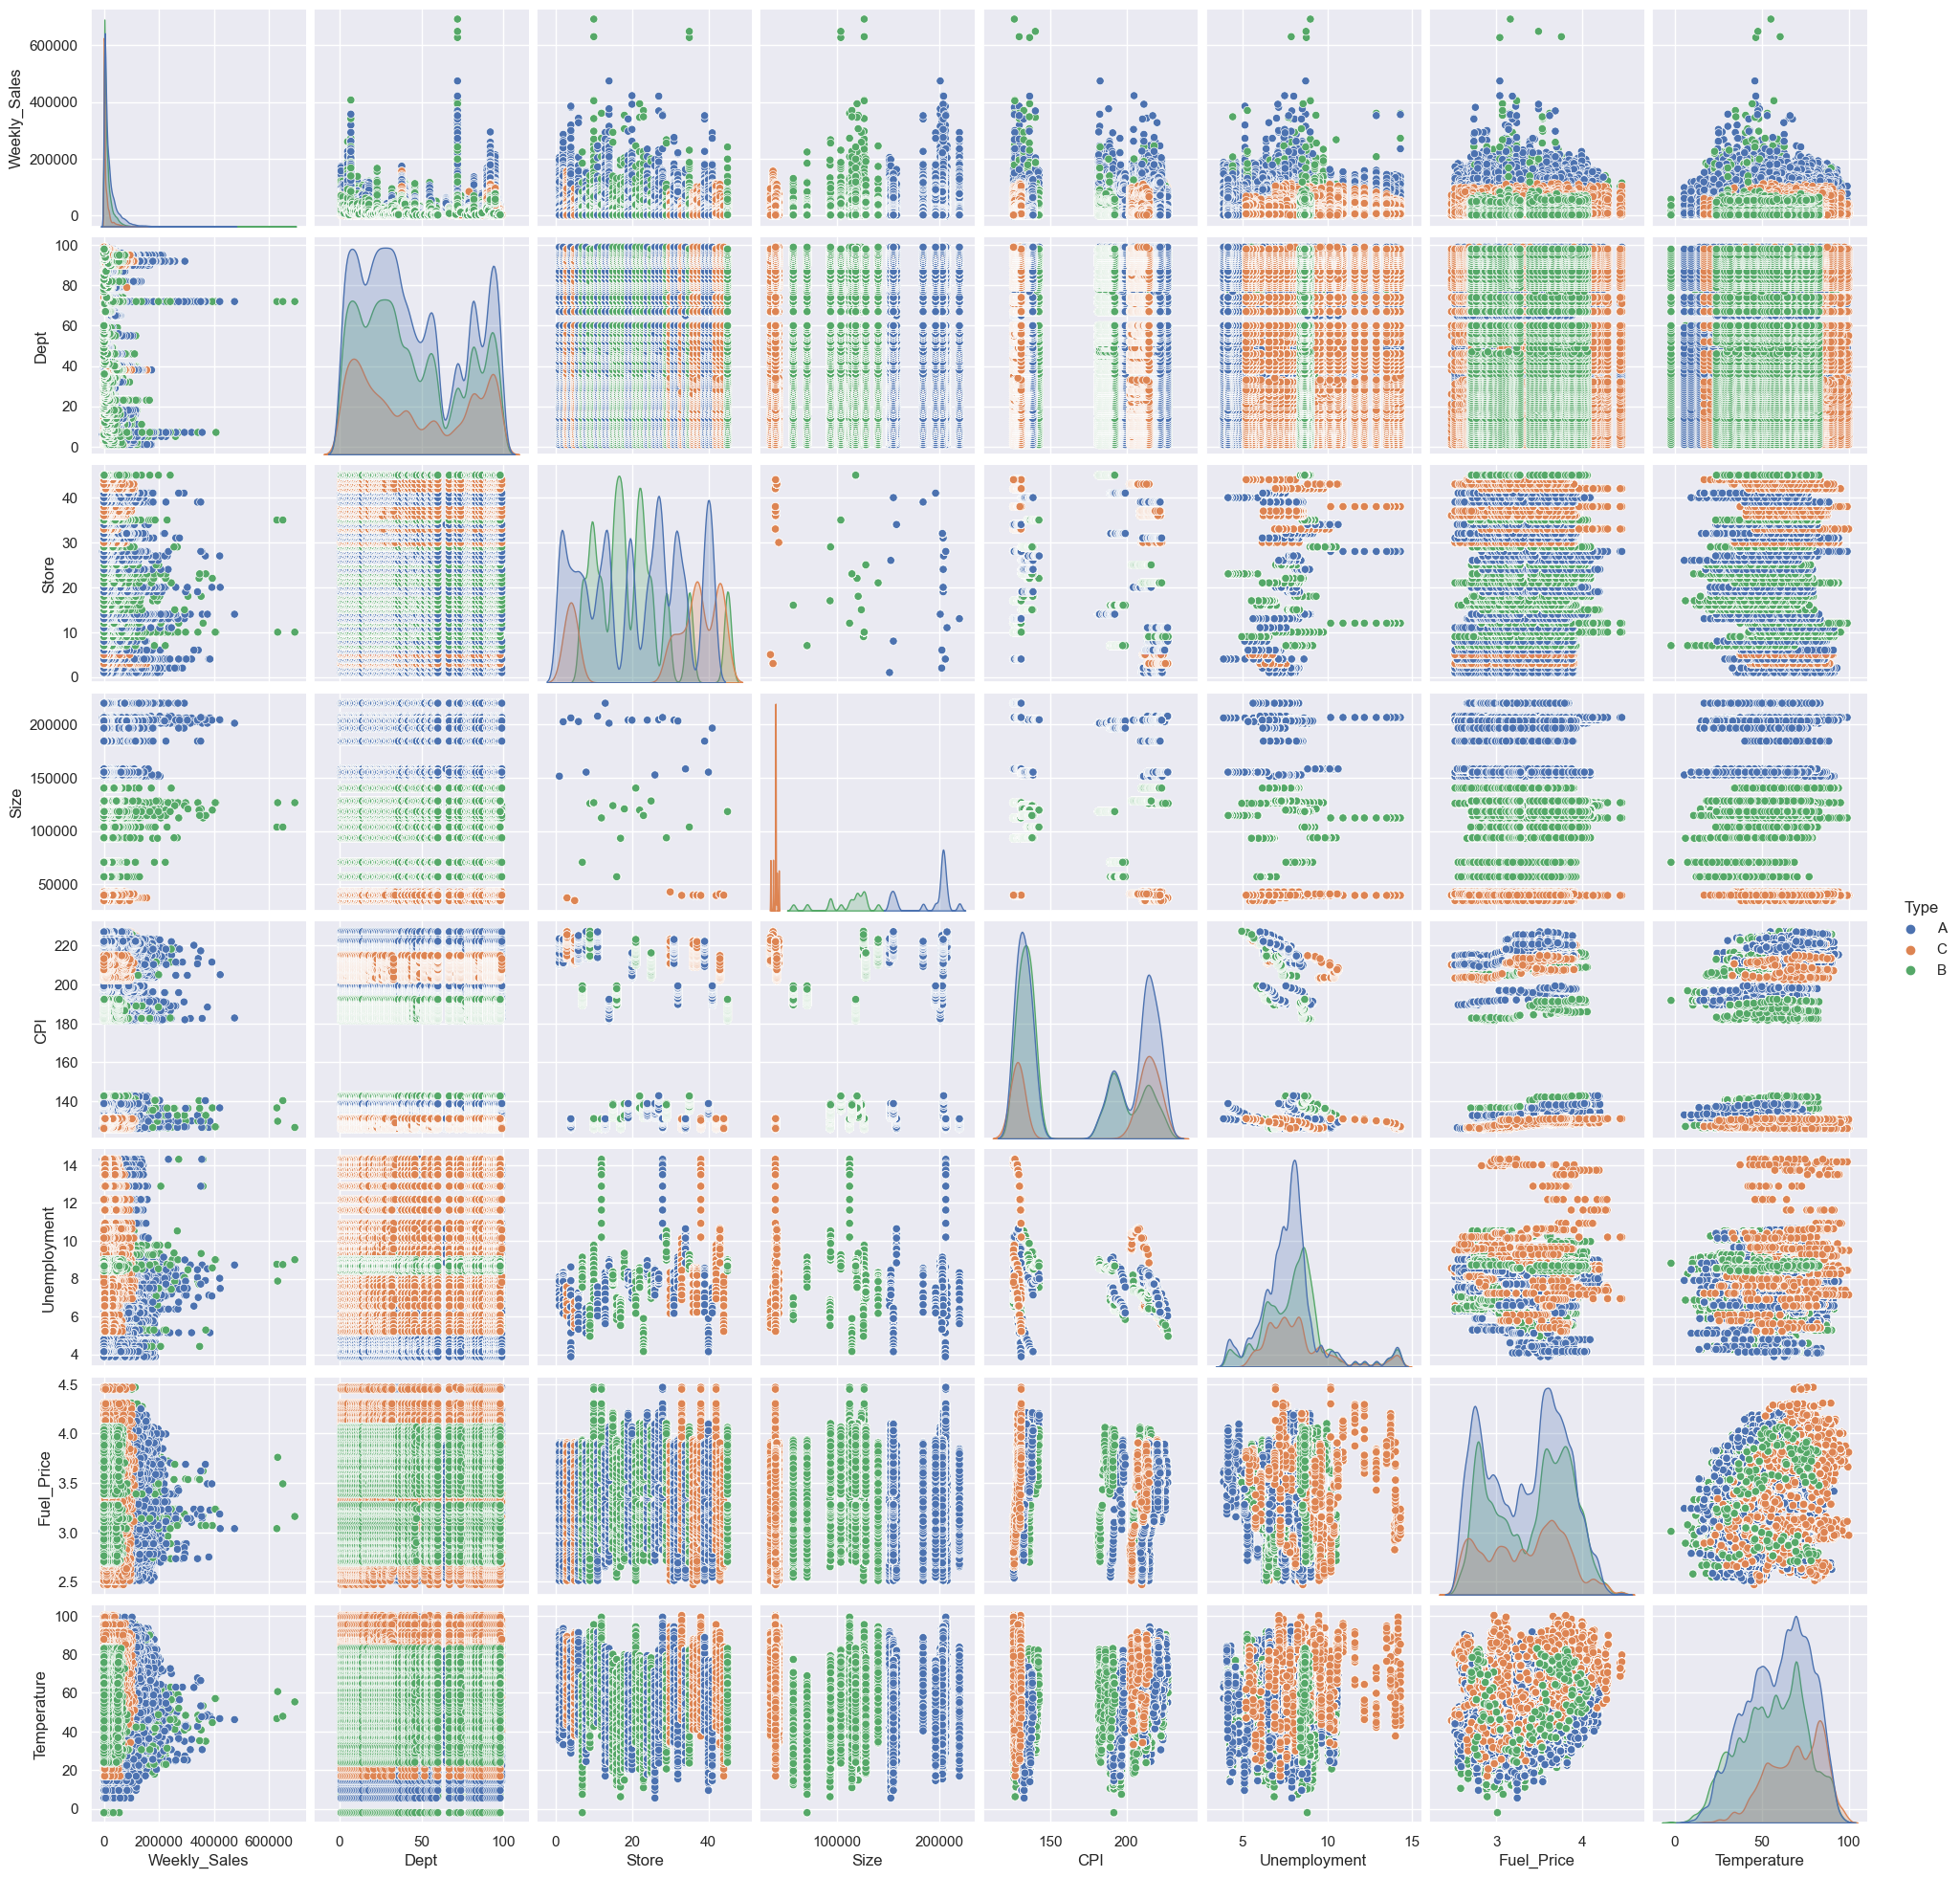

In [86]:
sns.pairplot(comb_data, vars=['Weekly_Sales', 'Dept', 'Store', 'Size', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature'], hue='Type')

C:\Users\ar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


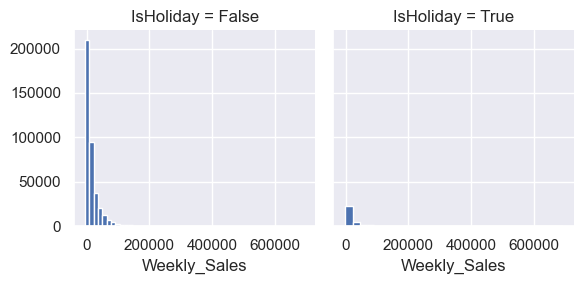

In [87]:
holiday = sns.FacetGrid(comb_data, col='IsHoliday')
holiday.map(plt.hist, 'Weekly_Sales', bins=30)

In [88]:
comb_data = comb_data.applymap(lambda x: 1 if x == True else x)
comb_data = comb_data.applymap(lambda x: 0 if x == False else x)

In [89]:
#comb_data["Date"] = pd.to_datetime(comb_data["Date"])
comb_data.Date = pd.to_datetime(comb_data.Date)

In [90]:
clean_data = comb_data[comb_data['Weekly_Sales']>0]

In [91]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420212 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         420212 non-null  int64         
 1   Dept          420212 non-null  int64         
 2   Date          420212 non-null  datetime64[ns]
 3   Weekly_Sales  420212 non-null  float64       
 4   IsHoliday     420212 non-null  int64         
 5   Temperature   420212 non-null  float64       
 6   Fuel_Price    420212 non-null  float64       
 7   MarkDown1     420212 non-null  float64       
 8   MarkDown2     420212 non-null  float64       
 9   MarkDown3     420212 non-null  float64       
 10  MarkDown4     420212 non-null  float64       
 11  MarkDown5     420212 non-null  float64       
 12  CPI           420212 non-null  float64       
 13  Unemployment  420212 non-null  float64       
 14  Type          420212 non-null  object        
 15  Size          420212 n

In [92]:
clean_data1 = clean_data[clean_data["Type"] == "A"] 

In [93]:
clean_data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202286 entries, 0 to 391059
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         202286 non-null  int64         
 1   Dept          202286 non-null  int64         
 2   Date          202286 non-null  datetime64[ns]
 3   Weekly_Sales  202286 non-null  float64       
 4   IsHoliday     202286 non-null  int64         
 5   Temperature   202286 non-null  float64       
 6   Fuel_Price    202286 non-null  float64       
 7   MarkDown1     202286 non-null  float64       
 8   MarkDown2     202286 non-null  float64       
 9   MarkDown3     202286 non-null  float64       
 10  MarkDown4     202286 non-null  float64       
 11  MarkDown5     202286 non-null  float64       
 12  CPI           202286 non-null  float64       
 13  Unemployment  202286 non-null  float64       
 14  Type          202286 non-null  object        
 15  Size          202286 n

In [94]:
clean_data1.describe(include='all')

Store           Dept                           Date  \
count   202286.000000  202286.000000                         202286   
unique            NaN            NaN                            NaN   
top               NaN            NaN                            NaN   
freq              NaN            NaN                            NaN   
mean        20.934326      44.485570  2011-06-17 05:48:24.865388288   
min          1.000000       1.000000            2010-02-05 00:00:00   
25%          8.000000      20.000000            2010-10-08 00:00:00   
50%         20.000000      37.500000            2011-06-17 00:00:00   
75%         31.000000      72.000000            2012-02-24 00:00:00   
max         41.000000      99.000000            2012-10-26 00:00:00   
std         12.754509      30.036683                            NaN   

         Weekly_Sales      IsHoliday    Temperature     Fuel_Price  \
count   202286.000000  202286.000000  202286.000000  202286.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean     20962.814036       0.070549      59.682803       3.340252   
min          0.010000       0.000000       5.540000       2.514000   
25%       3756.900000       0.000000      46.420000       2.906000   
50%      10879.935000       0.000000      62.010000       3.415000   
75%      27566.712500       0.000000      74.100000       3.717000   
max     474330.100000       1.000000      99.220000       4.468000   
std      26898.626654       0.256070      17.991029       0.456896   

            MarkDown1      MarkDown2      MarkDown3      MarkDown4  \
count   202286.000000  202286.000000  202286.000000  202286.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean      3290.207260    1146.760225     584.821624    1409.380958   
min          0.000000    -265.760000     -29.100000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%       4864.300000      32.040000      11.850000     919.320000   
max      78124.500000   97740.990000  109030.750000   67474.850000   
std       6827.151864    6000.218287    6194.194569    4537.213118   

            MarkDown5            CPI   Unemployment    Type           Size  
count   202286.000000  202286.000000  202286.000000  202286  202286.000000  
unique            NaN            NaN            NaN       1            NaN  
top               NaN            NaN            NaN       A            NaN  
freq              NaN            NaN            NaN  202286            NaN  
mean      2247.480669     174.610036       7.766532     NaN  191149.743017  
min          0.000000     126.064000       3.879000     NaN  151315.000000  
25%          0.000000     132.751667       6.901000     NaN  184109.000000  
50%          0.000000     189.662884       7.806000     NaN  203007.000000  
75%       3430.560000     214.118080       8.326000     NaN  204184.000000  
max     108519.280000     227.036936      14.313000     NaN  219622.000000  
std       5338.825440      39.249815       1.744491     NaN   21961.735467

In [96]:
clean_data1['Week'] = clean_data1['Date'].dt.isocalendar().week
clean_data1['Year'] = clean_data1['Date'].dt.year

C:\Users\ar\AppData\Local\Temp\ipykernel_4668\3223798882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data1['Week'] = clean_data1['Date'].dt.isocalendar().week
C:\Users\ar\AppData\Local\Temp\ipykernel_4668\3223798882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data1['Year'] = clean_data1['Date'].dt.year


In [102]:
clean_data1[['Dept', 'Weekly_Sales']].groupby(['Dept'], as_index=False).mean().sort_values(by='Weekly_Sales', ascending=False)

Dept   Weekly_Sales
73    92  119434.208462
76    95  103465.496752
71    90   74586.846629
36    38   69920.036122
60    72   62415.554941
..   ...            ...
49    51      23.226359
43    45      22.558960
63    78      10.762018
37    39       9.998667
41    43       0.705000

[81 rows x 2 columns]

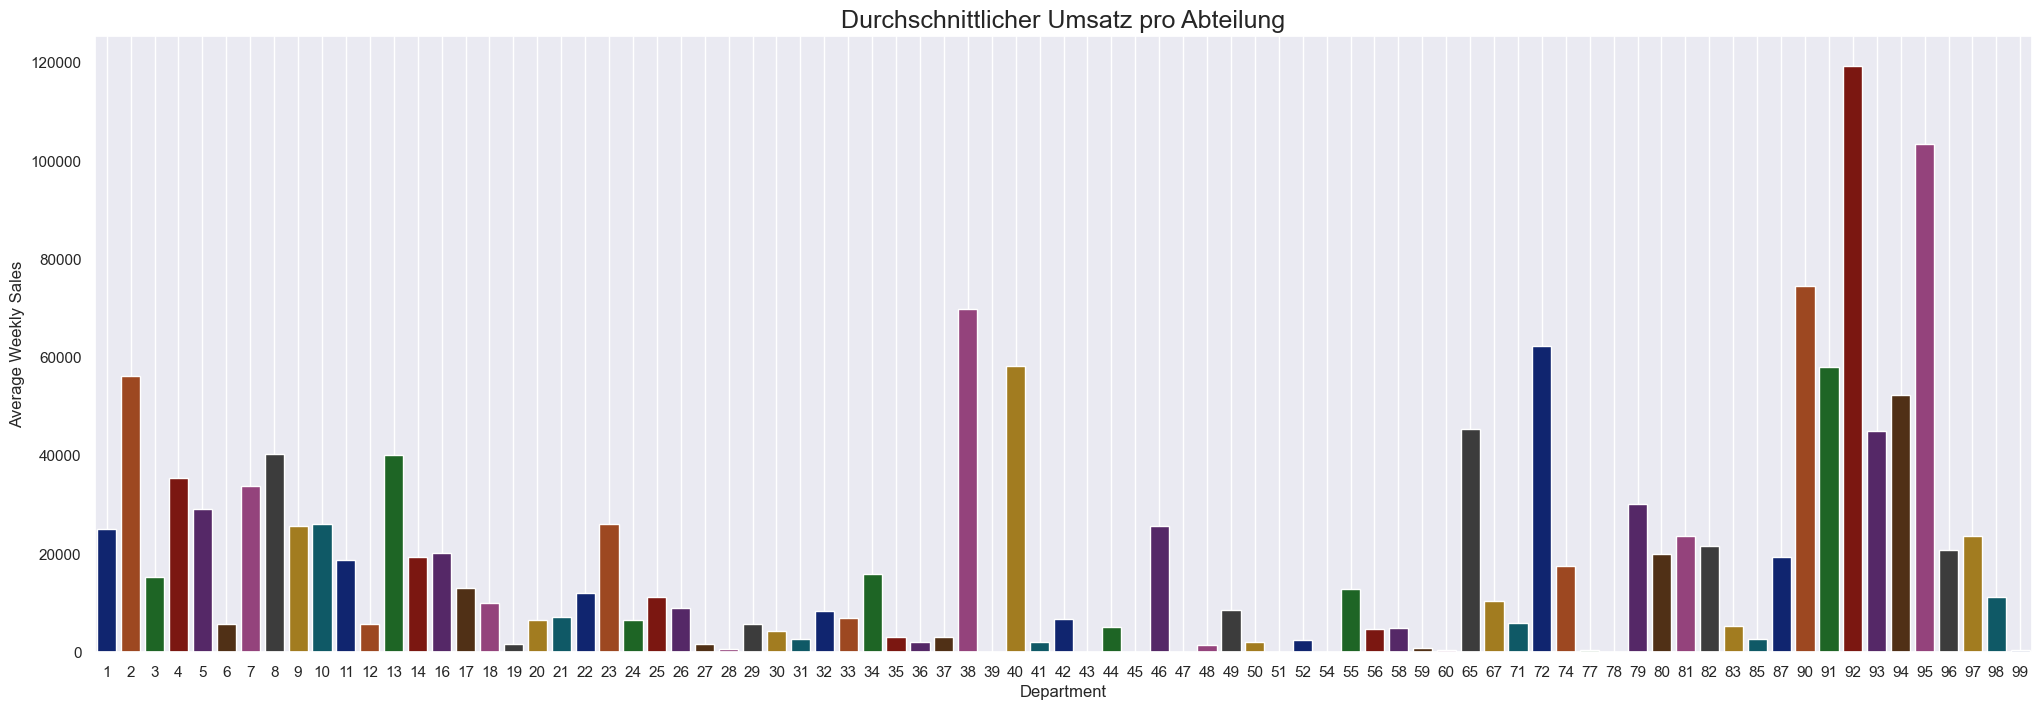

In [104]:
# Calculate the mean weekly sales per department
weekly_sales = clean_data1.groupby('Dept')['Weekly_Sales'].mean()

plt.figure(figsize=(25, 8))

# Use keyword arguments for sns.barplot
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='dark')
plt.grid()
plt.title('Durchschnittlicher Umsatz pro Abteilung', fontsize=18)
plt.xlabel('Department')
plt.ylabel('Average Weekly Sales')
plt.show()

C:\Users\ar\AppData\Local\Temp\ipykernel_4668\2725126300.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clean_data1['Weekly_Sales'])


<Axes: xlabel='Weekly_Sales', ylabel='Density'>

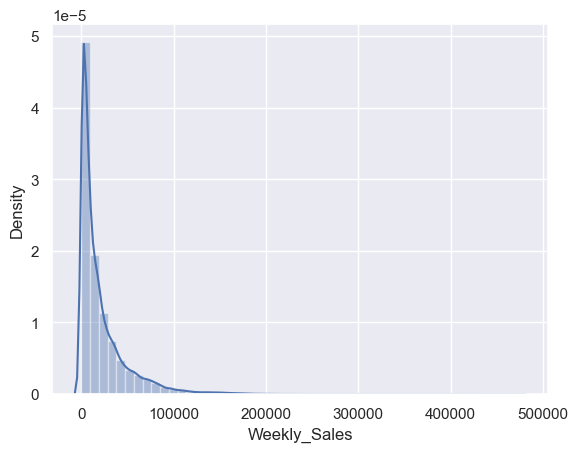

In [105]:
sns.distplot(clean_data1['Weekly_Sales'])  

In [106]:
clean_data2 = clean_data1[clean_data1["Dept"] == 92] 

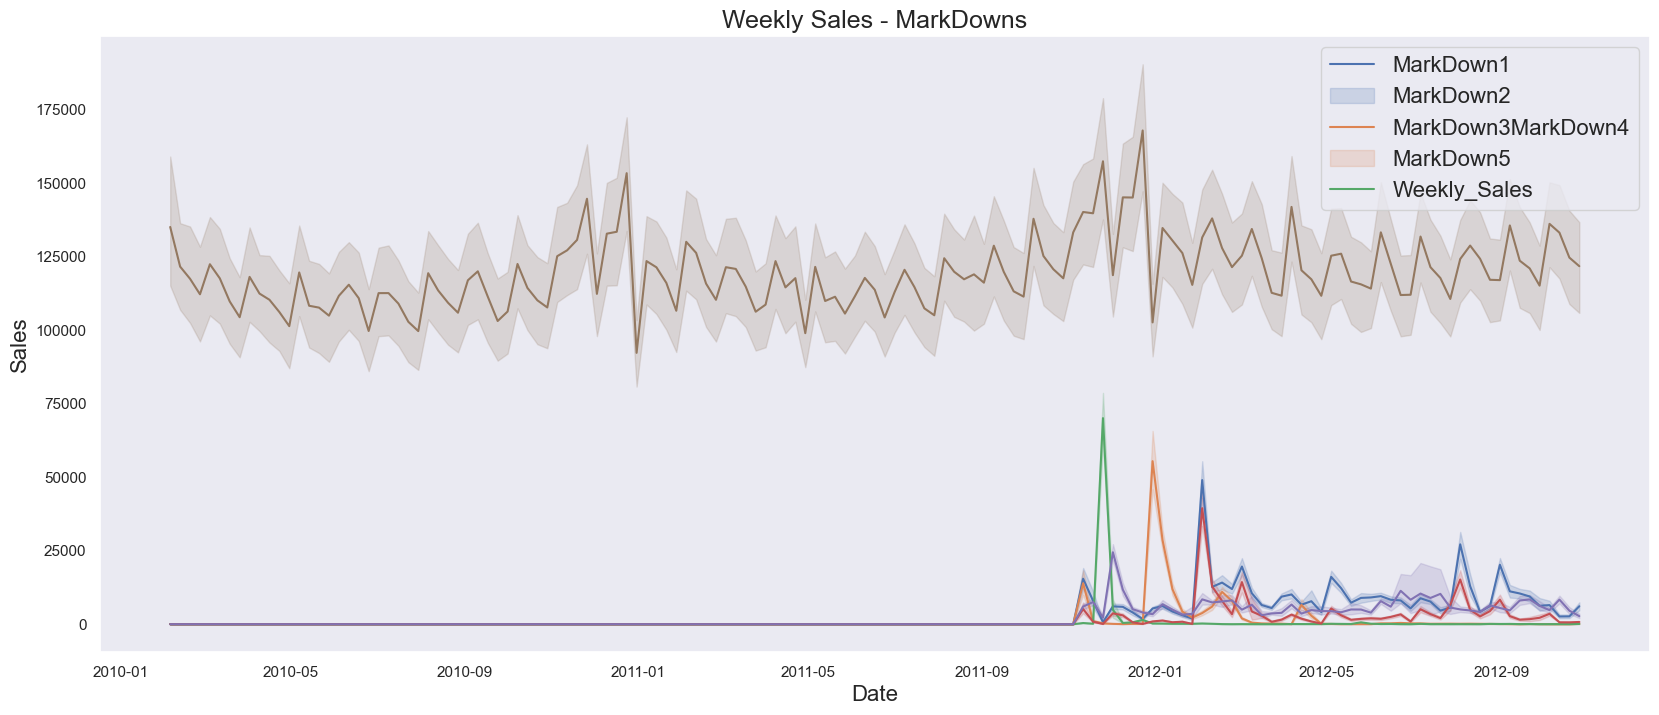

In [109]:
plt.figure(figsize=(20,8))
sns.lineplot(x="Date", y="MarkDown1", data=clean_data2)
sns.lineplot(x="Date", y="MarkDown2", data=clean_data2)
sns.lineplot(x="Date", y="MarkDown3", data=clean_data2)
sns.lineplot(x="Date", y="MarkDown4", data=clean_data2)
sns.lineplot(x="Date", y="MarkDown5", data=clean_data2)

sns.lineplot(x="Date", y="Weekly_Sales", data=clean_data2)
plt.grid()
plt.legend(['MarkDown1', 'MarkDown2', 'MarkDown3' 'MarkDown4', 'MarkDown5', 'Weekly_Sales'], loc='best', fontsize=16)
plt.title('Weekly Sales - MarkDowns', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

C:\Users\ar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


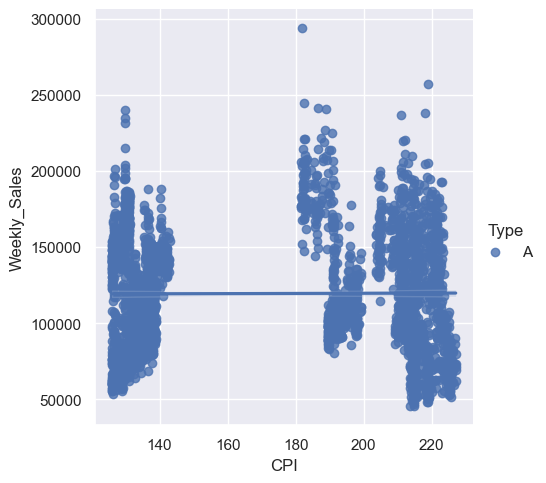

In [110]:
sns.lmplot(x='CPI',y='Weekly_Sales',data=clean_data2,hue='Type')

C:\Users\ar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


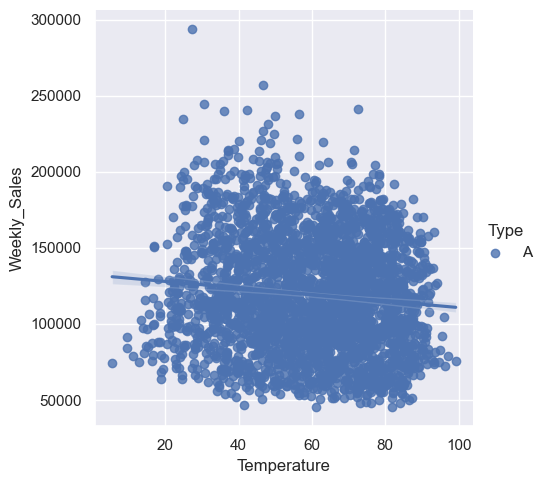

In [111]:
sns.lmplot(x='Temperature',y='Weekly_Sales',data=clean_data2,hue='Type')

C:\Users\ar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


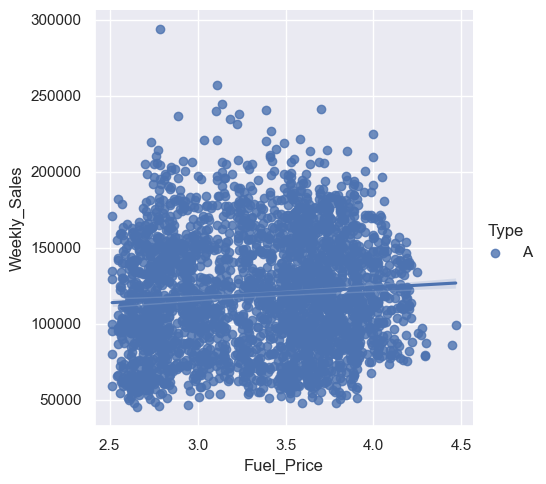

In [112]:
sns.lmplot(x='Fuel_Price',y='Weekly_Sales',data=clean_data2,hue='Type')

C:\Users\ar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


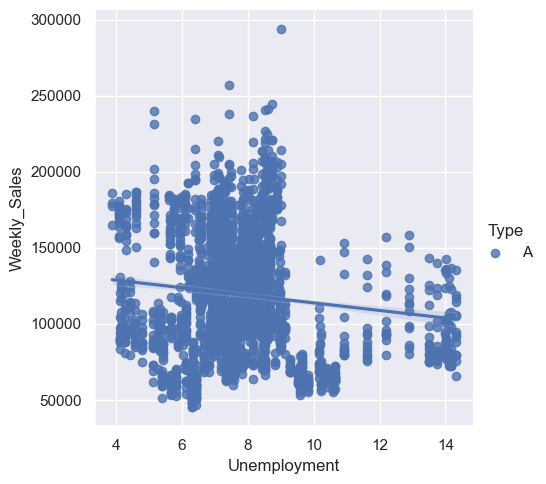

In [113]:
sns.lmplot(x='Unemployment',y='Weekly_Sales',data=clean_data2,hue='Type')

C:\Users\ar\AppData\Local\Temp\ipykernel_4668\2156329498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clean_data2['Weekly_Sales'])


<Axes: xlabel='Weekly_Sales', ylabel='Density'>

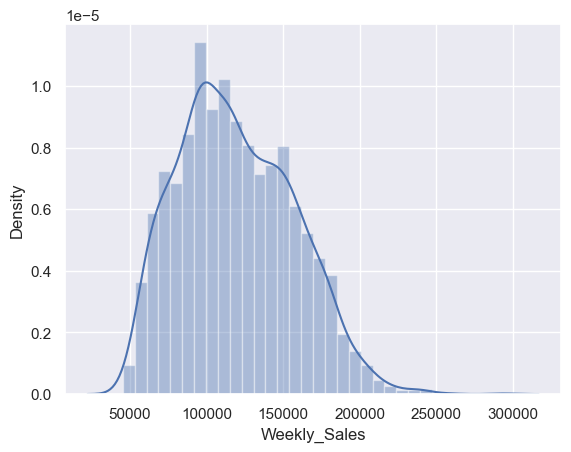

In [115]:
sns.distplot(clean_data2['Weekly_Sales'])

<Axes: >

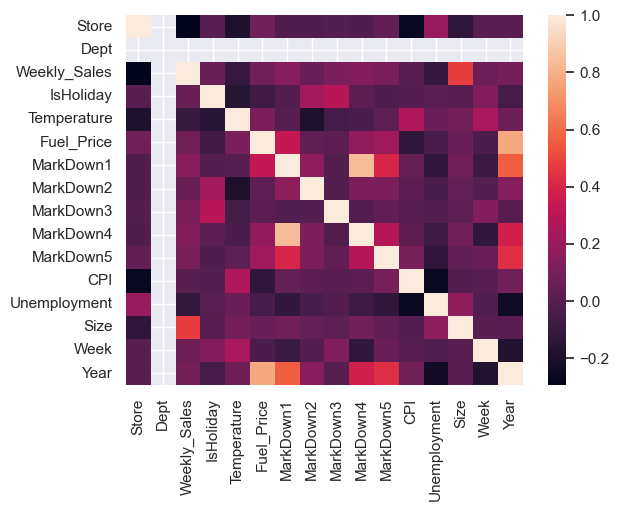

In [117]:
numeric_data = clean_data2.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr())

In [119]:
clean_data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2860 entries, 9227 to 390158
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         2860 non-null   int64         
 1   Dept          2860 non-null   int64         
 2   Date          2860 non-null   datetime64[ns]
 3   Weekly_Sales  2860 non-null   float64       
 4   IsHoliday     2860 non-null   int64         
 5   Temperature   2860 non-null   float64       
 6   Fuel_Price    2860 non-null   float64       
 7   MarkDown1     2860 non-null   float64       
 8   MarkDown2     2860 non-null   float64       
 9   MarkDown3     2860 non-null   float64       
 10  MarkDown4     2860 non-null   float64       
 11  MarkDown5     2860 non-null   float64       
 12  CPI           2860 non-null   float64       
 13  Unemployment  2860 non-null   float64       
 14  Type          2860 non-null   object        
 15  Size          2860 non-null   int64   

In [125]:
object_columns = clean_data2.select_dtypes(include=['object']).columns
clean_data2[object_columns] = clean_data2[object_columns].apply(pd.to_numeric, errors='coerce')
clean_data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2860 entries, 9227 to 390158
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         2860 non-null   int64         
 1   Dept          2860 non-null   int64         
 2   Date          2860 non-null   datetime64[ns]
 3   Weekly_Sales  2860 non-null   float64       
 4   IsHoliday     2860 non-null   int64         
 5   Temperature   2860 non-null   float64       
 6   Fuel_Price    2860 non-null   float64       
 7   MarkDown1     2860 non-null   float64       
 8   MarkDown2     2860 non-null   float64       
 9   MarkDown3     2860 non-null   float64       
 10  MarkDown4     2860 non-null   float64       
 11  MarkDown5     2860 non-null   float64       
 12  CPI           2860 non-null   float64       
 13  Unemployment  2860 non-null   float64       
 14  Type          0 non-null      float64       
 15  Size          2860 non-null   int64   

In [126]:
# Dropping data columns
clean_data2 = clean_data2.drop(columns=['Date'])

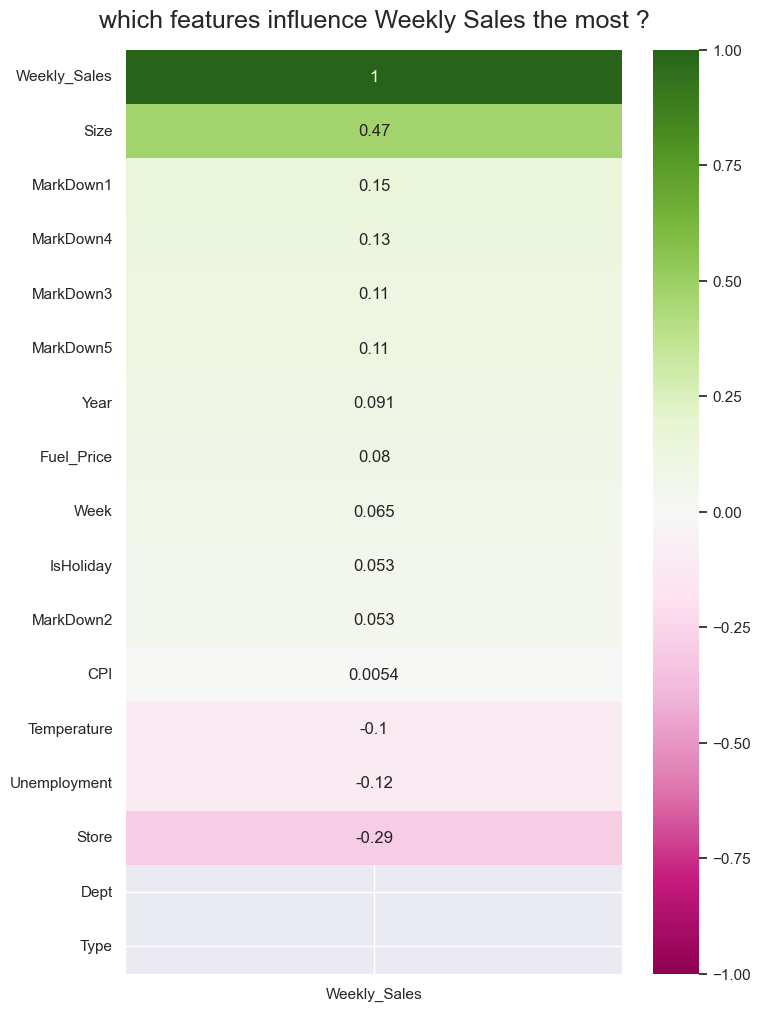

In [127]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(clean_data2.corr()[['Weekly_Sales']].sort_values(by='Weekly_Sales', ascending=False), vmin=-1, vmax=1, annot=True, cmap='PiYG')
heatmap.set_title('which features influence Weekly Sales the most ?', fontdict={'fontsize':18}, pad=16);

In [128]:
clean_data2.isnull().sum()

Store              0
Dept               0
Weekly_Sales       0
IsHoliday          0
Temperature        0
Fuel_Price         0
MarkDown1          0
MarkDown2          0
MarkDown3          0
MarkDown4          0
MarkDown5          0
CPI                0
Unemployment       0
Type            2860
Size               0
Week               0
Year               0
dtype: int64

In [129]:
clean_data3 = clean_data2.drop(['CPI', 'Fuel_Price', 'Dept'], axis = 1) 

In [130]:
clean_data3.isnull().sum() 

Store              0
Weekly_Sales       0
IsHoliday          0
Temperature        0
MarkDown1          0
MarkDown2          0
MarkDown3          0
MarkDown4          0
MarkDown5          0
Unemployment       0
Type            2860
Size               0
Week               0
Year               0
dtype: int64

<Axes: >

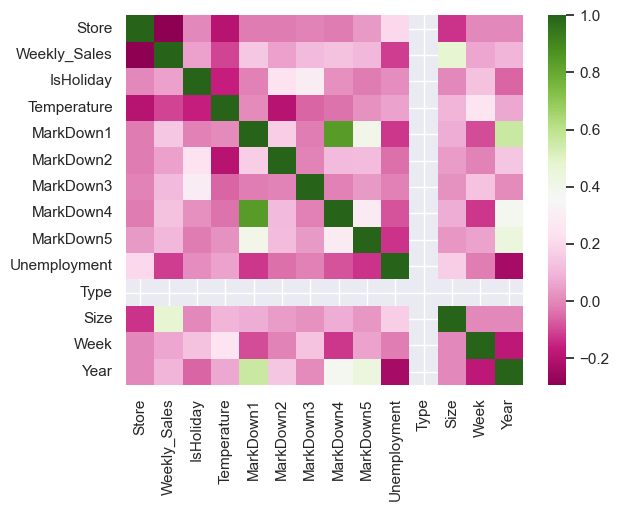

In [131]:
sns.heatmap(clean_data3.corr(),cmap="PiYG")

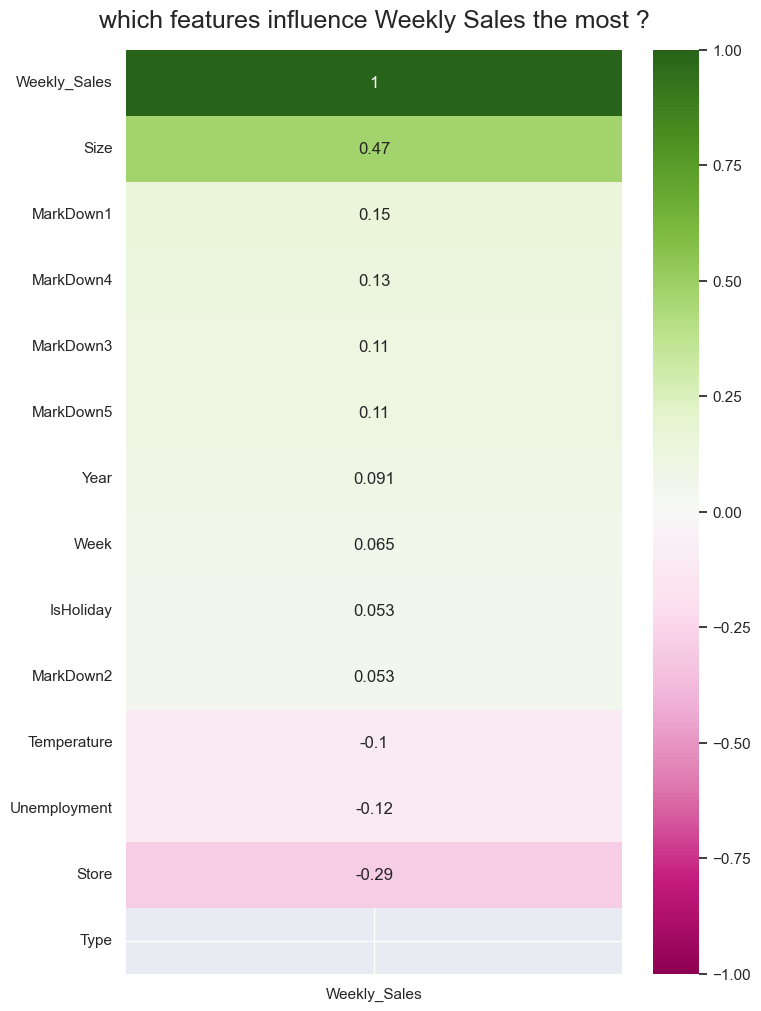

In [132]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(clean_data3.corr()[['Weekly_Sales']].sort_values(by='Weekly_Sales', ascending=False), vmin=-1, vmax=1, annot=True, cmap='PiYG')
heatmap.set_title('which features influence Weekly Sales the most ?', fontdict={'fontsize':18}, pad=16);

## 3.2. Resetting Index

- Deleting observations preserves the original indices
- Deleting observations with indices 2 and 3 will result in an index like: 0,1,4,5,6
- Once we reset the index, a new column is created that contains the old index
- Use 'drop=True' to delete the old index completely

In [134]:
clean_data4 = clean_data3.reset_index(drop=True)  
clean_data4.describe(include='all')

Store   Weekly_Sales    IsHoliday  Temperature     MarkDown1  \
count  2860.000000    2860.000000  2860.000000  2860.000000   2860.000000   
mean     21.000000  119434.208462     0.069930    59.737063   3274.485661   
std      12.761542   37562.653935     0.255074    18.000214   6803.391970   
min       1.000000   45263.340000     0.000000     5.540000      0.000000   
25%      10.250000   91257.565000     0.000000    46.507500      0.000000   
50%      22.000000  115690.535000     0.000000    62.045000      0.000000   
75%      31.250000  147571.427500     0.000000    74.142500   4833.170000   
max      41.000000  293966.050000     1.000000    99.220000  78124.500000   

          MarkDown2      MarkDown3     MarkDown4      MarkDown5  Unemployment  \
count   2860.000000    2860.000000   2860.000000    2860.000000   2860.000000   
mean    1136.812409     570.622937   1396.637923    2246.015262      7.765653   
std     5966.226600    6110.689225   4506.434693    5378.014318      1.745066   
min     -265.760000     -29.100000      0.000000       0.000000      3.879000   
25%        0.000000       0.000000      0.000000       0.000000      6.901000   
50%        0.000000       0.000000      0.000000       0.000000      7.806000   
75%       31.337500      11.165000    916.982500    3422.680000      8.326000   
max    97740.990000  109030.750000  67474.850000  108519.280000     14.313000   

       Type           Size       Week         Year  
count   0.0    2860.000000     2860.0  2860.000000  
mean    NaN  190992.500000  25.818182  2010.965035  
std     NaN   21992.587981  14.130574     0.797097  
min     NaN  151315.000000        1.0  2010.000000  
25%     NaN  177610.250000       14.0  2010.000000  
50%     NaN  202756.000000       26.0  2011.000000  
75%     NaN  203910.250000       38.0  2012.000000  
max     NaN  219622.000000       52.0  2012.000000

## 3.3. Test for Multicollinearity


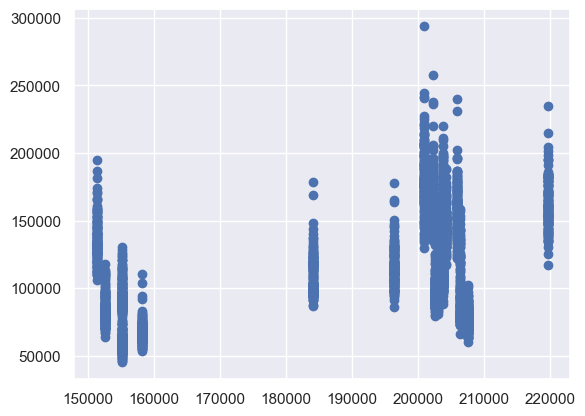

In [135]:
plt.scatter(clean_data4['Size'], clean_data3['Weekly_Sales'])  # eine lineare Funktion sollte entstehen - nicht exponentielle Funktion

Violation of OLS Assumption --> no Linearity Solution then perform a Log Transformation

In [136]:
log_sales = np.log(clean_data4['Weekly_Sales'])
clean_data4['log_sales'] = log_sales
clean_data4

Store  Weekly_Sales  IsHoliday  Temperature  MarkDown1  MarkDown2  \
0         1     139884.94          0        42.31       0.00       0.00   
1         1     143081.42          1        38.51       0.00       0.00   
2         1     135066.75          0        39.93       0.00       0.00   
3         1     125048.08          0        46.63       0.00       0.00   
4         1     132945.44          0        46.50       0.00       0.00   
...     ...           ...        ...          ...        ...        ...   
2855     41     128422.98          0        56.08    4578.46      51.73   
2856     41     142134.06          0        50.14    6094.23       0.00   
2857     41     145984.90          0        39.38    1570.23       0.00   
2858     41     132903.53          0        49.56    3138.86       0.00   
2859     41     131128.24          0        41.80    4864.30     101.34   

      MarkDown3  MarkDown4  MarkDown5  Unemployment  Type    Size  Week  Year  \
0          0.00       0.00       0.00         8.106   NaN  151315     5  2010   
1          0.00       0.00       0.00         8.106   NaN  151315     6  2010   
2          0.00       0.00       0.00         8.106   NaN  151315     7  2010   
3          0.00       0.00       0.00         8.106   NaN  151315     8  2010   
4          0.00       0.00       0.00         8.106   NaN  151315     9  2010   
...         ...        ...        ...           ...   ...     ...   ...   ...   
2855       3.00    1902.88   14423.97         6.432   NaN  196321    39  2012   
2856      33.94    2887.65    3853.33         6.195   NaN  196321    40  2012   
2857      26.31     834.80   14421.12         6.195   NaN  196321    41  2012   
2858       6.17     129.04    8206.10         6.195   NaN  196321    42  2012   
2859     250.60      47.24    1524.43         6.195   NaN  196321    43  2012   

      log_sales  
0     11.848576  
1     11.871169  
2     11.813524  
3     11.736454  
4     11.797694  
...         ...  
2855  11.763085  
2856  11.864526  
2857  11.891258  
2858  11.797379  
2859  11.783931  

[2860 rows x 15 columns]

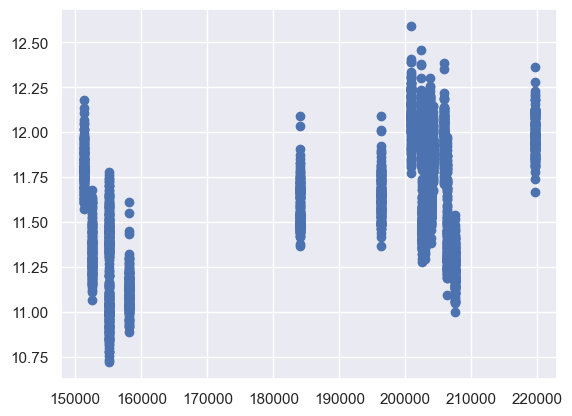

In [137]:
plt.scatter(clean_data4['Size'], clean_data4['log_sales'])

In [138]:
clean_data4 = clean_data4.drop(['Weekly_Sales'], axis=1)

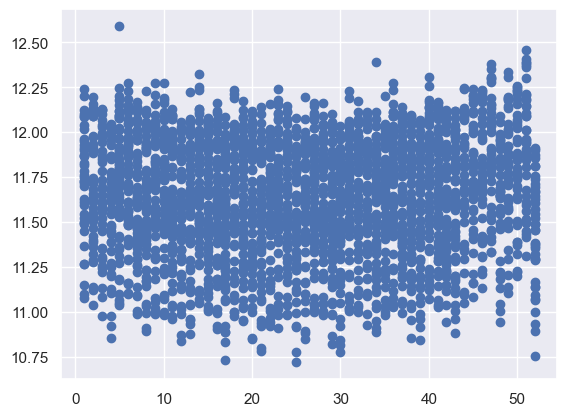

In [139]:
plt.scatter(clean_data4['Week'], clean_data4['log_sales'])

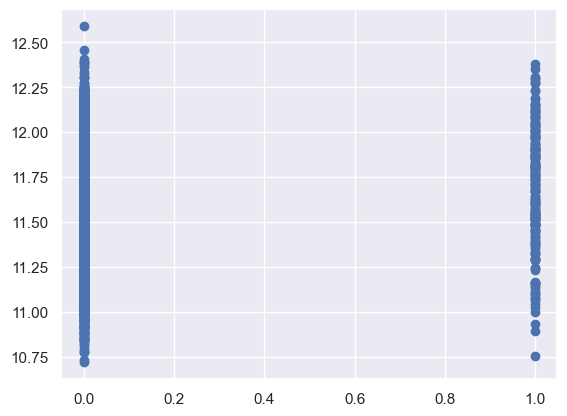

In [140]:
plt.scatter(clean_data4['IsHoliday'], clean_data4['log_sales'])

Assumption no Multicollinearity

In [142]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# variables = clean_data4[['Week', 'Year', 'Size']]   
# vif = pd.DataFrame() 
# vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# vif["Features"] = variables.columns
# vif

In [144]:
data_no_multi = clean_data4.drop(['Year'], axis=1)

## 3.4. Creating Dummy Variables

In [145]:
data_with_dummies = pd.get_dummies(data_no_multi, drop_first=True)   # drop_first=true: die erste Ausprägung aller categorialen Werte wird weggelassen

In [146]:
data_with_dummies.head()

Store  IsHoliday  Temperature  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0      1          0        42.31        0.0        0.0        0.0        0.0   
1      1          1        38.51        0.0        0.0        0.0        0.0   
2      1          0        39.93        0.0        0.0        0.0        0.0   
3      1          0        46.63        0.0        0.0        0.0        0.0   
4      1          0        46.50        0.0        0.0        0.0        0.0   

   MarkDown5  Unemployment  Type    Size  Week  log_sales  
0        0.0         8.106   NaN  151315     5  11.848576  
1        0.0         8.106   NaN  151315     6  11.871169  
2        0.0         8.106   NaN  151315     7  11.813524  
3        0.0         8.106   NaN  151315     8  11.736454  
4        0.0         8.106   NaN  151315     9  11.797694

In [147]:
data_with_dummies.columns.values

array(['Store', 'IsHoliday', 'Temperature', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'Unemployment', 'Type',
       'Size', 'Week', 'log_sales'], dtype=object)

In [150]:
cols=['log_sales', 'Store', 'IsHoliday', 'Size', 'Week', 'Temperature', 'Unemployment', 'MarkDown1', 'MarkDown2','MarkDown3', 'MarkDown4', 'MarkDown5']
#cols=['log_sales', 'Store', 'IsHoliday', 'Size', 'Week', 'Temperature', 'Unemployment'] # because the R² improves if we keep these values in

In [152]:
data_preprocessed = data_with_dummies[cols]
data_preprocessed.head()

log_sales  Store  IsHoliday    Size  Week  Temperature  Unemployment  \
0  11.848576      1          0  151315     5        42.31         8.106   
1  11.871169      1          1  151315     6        38.51         8.106   
2  11.813524      1          0  151315     7        39.93         8.106   
3  11.736454      1          0  151315     8        46.63         8.106   
4  11.797694      1          0  151315     9        46.50         8.106   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  
0        0.0        0.0        0.0        0.0        0.0  
1        0.0        0.0        0.0        0.0        0.0  
2        0.0        0.0        0.0        0.0        0.0  
3        0.0        0.0        0.0        0.0        0.0  
4        0.0        0.0        0.0        0.0        0.0

## Local file
df_dummies.to_csv('train_dummies.csv', index = False) # full path if file should not be in the same folder as the notebook

## Cloud file
#project.save_data("train_dummies.csv", df_dummies.to_csv(index=False))

# 4. Modelling and Evaluation

## 4.1. Multiple Linear Regression Model

In [155]:
targets = data_preprocessed['log_sales']   # zielvariable
inputs = data_preprocessed.drop(['log_sales'], axis=1)

## 4.2. Feature Scaling

transforms our data into standard distributed data

In [156]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)
input_scaled = scaler.transform(inputs)

## 4.3. Test and Train Data

In [157]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_scaled, targets, test_size=0.2, random_state=365)

In [158]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression()

In [159]:
y_hat = reg.predict(x_train)

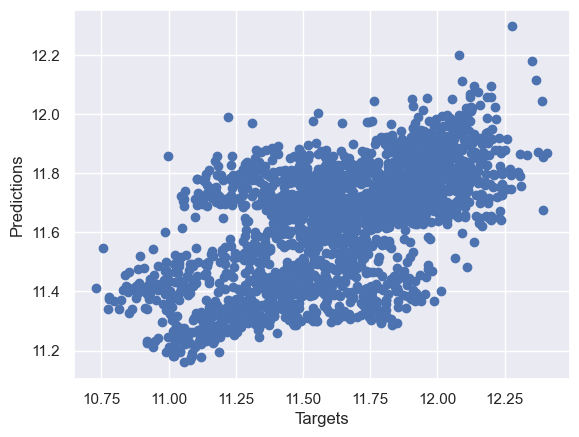

In [160]:
plt.scatter(y_train, y_hat)
plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.show()

C:\Users\ar\AppData\Local\Temp\ipykernel_4668\1343639121.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train - y_hat)


Text(0.5, 1.0, 'Residuals')

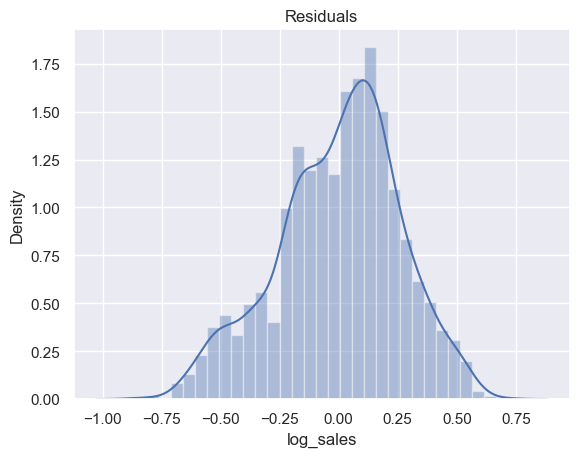

In [161]:
sns.distplot(y_train - y_hat)
plt.title("Residuals")

In [162]:
reg.score(x_train, y_train)

0.35803414778302856

The coefficient of determination R² is only about 35.8%. Presumably, another model has to be found, since these data are not useful for this purpose. Probably it is also because we have only taken the stores of type A and only the department 92 into consideration and thus a good forecast is not possible at all for everything.

In [163]:
reg.intercept_   

11.638698055432007

In [164]:
reg.coef_  

array([-0.05460284, -0.00297525,  0.1697551 ,  0.03078332, -0.06801271,
       -0.04136023,  0.02414852, -0.01160719,  0.01454898,  0.00087434,
        0.01764553])

In [165]:
reg_summary = pd.DataFrame(inputs.columns, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

Features   Weights
0          Store -0.054603
1      IsHoliday -0.002975
2           Size  0.169755
3           Week  0.030783
4    Temperature -0.068013
5   Unemployment -0.041360
6      MarkDown1  0.024149
7      MarkDown2 -0.011607
8      MarkDown3  0.014549
9      MarkDown4  0.000874
10     MarkDown5  0.017646

Size has the biggest effect on sales followed by the week, as expected. If we change the size by 1, then the turnover changes by 0.169.

In [166]:
y_hat_test = reg.predict(x_test)

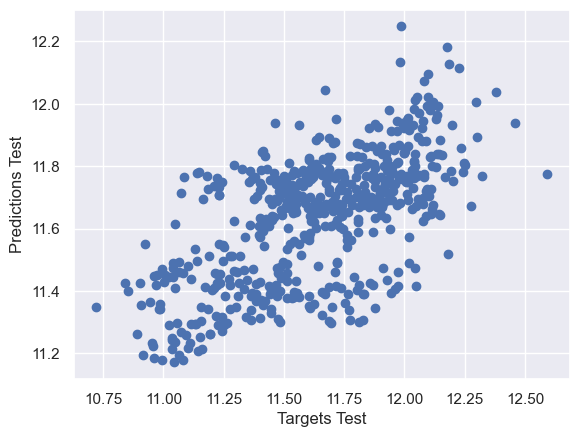

In [167]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Targets Test')
plt.ylabel('Predictions Test')
plt.show()

In [168]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Predictions'])
df_pf.head() 

Predictions
0  116819.417145
1  130998.419879
2   92313.264681
3   90837.833968
4  117826.572101

In [169]:
df_pf['Target'] = np.exp(y_test) 
df_pf.head()

Predictions     Target
0  116819.417145        NaN
1  130998.419879  143081.42
2   92313.264681        NaN
3   90837.833968        NaN
4  117826.572101        NaN

In [170]:
y_test = y_test.reset_index(drop=True)
y_test.head()

0    11.703337
1    12.038666
2    11.550857
3    11.463528
4    11.968262
Name: log_sales, dtype: float64

In [171]:
df_pf['Target'] = np.exp(y_test) 
df_pf.head()

Predictions     Target
0  116819.417145  120974.69
1  130998.419879  169171.18
2   92313.264681  103866.03
3   90837.833968   95180.23
4  117826.572101  157670.36

In [172]:
df_pf['Residuals'] = df_pf['Target'] - df_pf['Predictions']
df_pf

Predictions     Target     Residuals
0    116819.417145  120974.69   4155.272855
1    130998.419879  169171.18  38172.760121
2     92313.264681  103866.03  11552.765319
3     90837.833968   95180.23   4342.396032
4    117826.572101  157670.36  39843.787899
..             ...        ...           ...
567  109907.197654  116989.93   7082.732346
568  111919.500560   80209.05 -31710.450560
569   85980.050529  126907.41  40927.359471
570  140304.667673  155777.29  15472.622327
571  121242.374520   88335.66 -32906.714520

[572 rows x 3 columns]

In [173]:
df_pf['Difference%'] = np.absolute(df_pf['Residuals'] / df_pf['Target']*100)
df_pf   

Predictions     Target     Residuals  Difference%
0    116819.417145  120974.69   4155.272855     3.434828
1    130998.419879  169171.18  38172.760121    22.564576
2     92313.264681  103866.03  11552.765319    11.122756
3     90837.833968   95180.23   4342.396032     4.562288
4    117826.572101  157670.36  39843.787899    25.270309
..             ...        ...           ...          ...
567  109907.197654  116989.93   7082.732346     6.054138
568  111919.500560   80209.05 -31710.450560    39.534754
569   85980.050529  126907.41  40927.359471    32.249779
570  140304.667673  155777.29  15472.622327     9.932528
571  121242.374520   88335.66 -32906.714520    37.251903

[572 rows x 4 columns]

In [174]:
df_pf.describe()

Predictions         Target      Residuals  Difference%
count     572.000000     572.000000     572.000000   572.000000
mean   115670.583849  120025.710717    4355.126868    21.517588
std     22941.875293   39330.902460   31032.826964    17.482142
min     71040.429117   45263.340000  -63813.487107     0.127541
25%     94828.761143   90459.230000  -17799.809897     8.428694
50%    118220.278893  116320.655000    1400.734279    18.218184
75%    129494.110343  148368.807500   24456.722143    28.399692
max    208616.696105  293966.050000  163920.222512    98.055631